# Setup

In [67]:
import sys
# sys.path.append("/kaggle/input/python-helpers/") # Comment this out when you are not in Kaggle kernel
sys.path.append("../") # Comment this out when you are in local environment
import utils
from utils import (
    # General Functions
    check_memory_usage, check_memory_by_global_variable, # For memory handling
    get_time_now, cprint, # For logging
    get_cols, downcast_to_32bit, my_concat, my_power, my_log, list_diff, # For preprocessing
    plot_feature_importance, plot_scatterplot, # For visualization
    get_feature_summary, # For feature engineering & feature selection
    check_auc, plot_heatmap, # For EDA
    # Competition Constants
    META_COLUMNS, 
    # Competition Functions
    read_data, read_model, # Data Ingestion
    filter_df, check_target_dependency, # EDA
    calculate_psi, run_chi_square_tests, # Validation
    train_lgbm, # Model Training
    percentile, clean_df, get_price_clippers, get_volume_clippers, clip_df, # Pre-processing: Clean & Clip
    calc_robust_scale, calc_std_scale, scale_base_columns,  # Pre-processing: Scaling
    setup_validation_zip, # Simulation
    lgbm_inference_by_batch, # Inference
    zero_sum, # Post-processing
)
from utils import (
    calc_intraday_gradient
)

In [68]:
import gc
import joblib
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation
import math
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=12)
# import plotly.express as px
import random
import scipy.cluster.hierarchy as sch
import seaborn as sns
import time
import catboost
from catboost import CatBoostRegressor, Pool

from datetime import datetime
from itertools import combinations, groupby, product
from scipy.stats import pearsonr, chi2_contingency
from scipy.cluster.hierarchy import fcluster
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [69]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
DATA_DIR = '../data/'

In [71]:
joblib.__version__

'1.3.2'

# Test Simple Averaging Ensemble

In [72]:
%%time
# Read the final dataframe from feature engineering notebook
train = read_data(f'{DATA_DIR}/optiver-train-data/clipped_train.parquet')
train = downcast_to_32bit(train)

Before downcast: 	RAM used: 1.2 GB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 82.63it/s]

After downcast: 	RAM used: 1.1 GB
CPU times: user 332 ms, sys: 542 ms, total: 874 ms
Wall time: 446 ms


In [73]:
LGBM_MODEL_VERSION = 11
lgbm_val_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.txt'
lgbm_val_data_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}_val.csv'
lgbm_final_model_path = f'{DATA_DIR}/optiver-lgbm-models/lgbm_model{LGBM_MODEL_VERSION}.txt'

In [74]:
CAT_MODEL_VERSION = "4"
cat_val_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.cbm"
cat_val_data_path = f'{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}_val.csv'
cat_final_model_path = f"{DATA_DIR}/optiver-catboost-models/cat_model{CAT_MODEL_VERSION}.cbm"

In [75]:
cat_model = read_model(cat_val_model_path)

In [76]:
tr = filter_df(train, date_id=(421, 431))

In [77]:
# cat_model.predict(tr.loc[:, cat_model.feature_names_])

In [78]:
train = train[META_COLUMNS + ["target", "bid_size", "ask_size", "matched_size"]].copy()

In [79]:
cat = read_data(cat_val_data_path)
lgbm = read_data(lgbm_val_data_path)
lgbm["cat_pred"] = cat["val_pred"]
lgbm["final_pred"] = (.5 * lgbm["cat_pred"] + .5 * lgbm["val_pred"])
lgbm = lgbm.merge(train.drop(columns="target"), on=META_COLUMNS, how="left")
lgbm["final_pred_zero_sum"] = zero_sum(
    lgbm["final_pred"], 
    lgbm['bid_size'] + lgbm['ask_size']
)
(lgbm["final_pred_zero_sum"] - lgbm["target"]).abs().mean()

5.676577464689416

In [80]:
(lgbm["final_pred"] - lgbm["target"]).abs().mean()

5.676692593552781

In [81]:
(lgbm["val_pred"] - lgbm["target"]).abs().mean()

5.6783083552097855

In [82]:
(lgbm["cat_pred"] - lgbm["target"]).abs().mean()

5.681144318173251

In [52]:
daily_target_mean = train.groupby(["stock_id", "date_id"])["target"].mean().rename("daily_target_mean").reset_index()

In [55]:
daily_target_mean["ytd_daily_target_mean"] = daily_target_mean.groupby(["stock_id"])["daily_target_mean"].shift(1)

<Axes: >

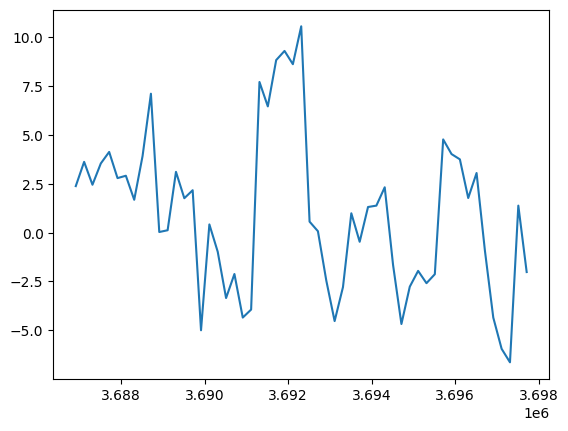

In [59]:
filter_df(train, stock_id=45, date_id=340)["target"].plot()

In [57]:
daily_target_mean.corr()

,stock_id,date_id,daily_target_mean,ytd_daily_target_mean
stock_id,1.000000,0.005047,0.000444,0.000291
date_id,0.005047,1.000000,0.003059,0.002523
daily_target_mean,0.000444,0.003059,1.000000,0.036355
ytd_daily_target_mean,0.000291,0.002523,0.036355,1.000000


In [46]:
lgbm = lgbm.merge(daily_target_mean, on=["stock_id", "date_id"])

In [50]:
lgbm

,stock_id,date_id,seconds,target,val_pred,cat_pred,final_pred,bid_size,ask_size,matched_size,final_pred_zero_sum,daily_target_mean,p
0,0,421,0,2.779961,-0.886043,-0.964363,-0.925203,16812.800781,26310.000000,11354174.0,-0.880980,0.028870,-0.018833
1,0,421,10,4.869700,-0.506639,-0.695024,-0.600832,51666.480469,13775.959961,11357118.0,-0.546354,0.028870,-0.002615
2,0,421,20,6.250143,-0.559653,-0.655453,-0.607553,17495.820312,5256.000000,11357118.0,-0.575431,0.028870,-0.002951
3,0,421,30,7.139444,-0.120479,-0.491777,-0.306128,20017.740234,11563.200195,11357118.0,-0.268283,0.028870,0.012120
4,0,421,40,8.139610,0.664026,0.365173,0.514600,315.239990,35891.648438,11799768.0,0.555121,0.028870,0.053157
...,...,...,...,...,...,...,...,...,...,...,...,...,...
659940,199,480,500,-7.209778,-1.822208,-2.112381,-1.967294,122246.179688,425296.156250,23969216.0,-1.809714,2.684723,2.452122
659941,199,480,510,-9.750128,-1.008363,-1.469890,-1.239127,677012.062500,347268.875000,23972082.0,-1.023600,2.684723,2.488531
659942,199,480,520,3.629923,1.485079,1.356815,1.420947,225361.656250,194630.515625,23978380.0,1.558957,2.684723,2.621534
659943,199,480,530,4.760027,0.963626,0.853138,0.908382,285559.062500,214513.312500,23978380.0,1.058976,2.684723,2.595906


In [49]:
for a in np.arange(0.05, 1, 0.05):
    lgbm["p"] = a * lgbm["daily_target_mean"] + (1 - a) * lgbm["final_pred"]
    mae = (lgbm["p"] - lgbm["target"]).abs().mean()
    cprint(f"{a}: {mae:.4f}", color="blue")

0.05: 5.6512
0.1: 5.6275
0.15000000000000002: 5.6061
0.2: 5.5871
0.25: 5.5706
0.3: 5.5566
0.35000000000000003: 5.5449
0.4: 5.5357
0.45: 5.5289
0.5: 5.5246
0.55: 5.5227
0.6000000000000001: 5.5231
0.6500000000000001: 5.5259
0.7000000000000001: 5.5310
0.7500000000000001: 5.5383
0.8: 5.5479
0.8500000000000001: 5.5597
0.9000000000000001: 5.5737
0.9500000000000001: 5.5899


In [180]:
c1 = read_data("../data/optiver-catboost-models/cat_model2_val.csv")
l1 = read_data("../data/optiver-lgbm-models/lgbm_model8_val.csv")

In [181]:
lgbm["cat_pred1"] = c1["cat_pred"]
lgbm["val_pred1"] = l1["val_pred"]

In [182]:
lgbm["final_pred"] = 0.25 * (lgbm["cat_pred1"] + lgbm["cat_pred"] + lgbm["val_pred"] + lgbm["val_pred1"])
(lgbm["final_pred"] - lgbm["target"]).abs().mean()

5.677299856265766

In [192]:
lgbm["p_final_pred2"] = zero_sum(
    lgbm["final_pred"], 
    lgbm["ask_size"] * np.abs(my_log(lgbm["ask_size_rbtsc"])) + lgbm["bid_size"] * np.abs(my_log(lgbm["bid_size_rbtsc"]))
)
(lgbm["p_final_pred2"] - lgbm["target"]).abs().mean()

5.677356032170784

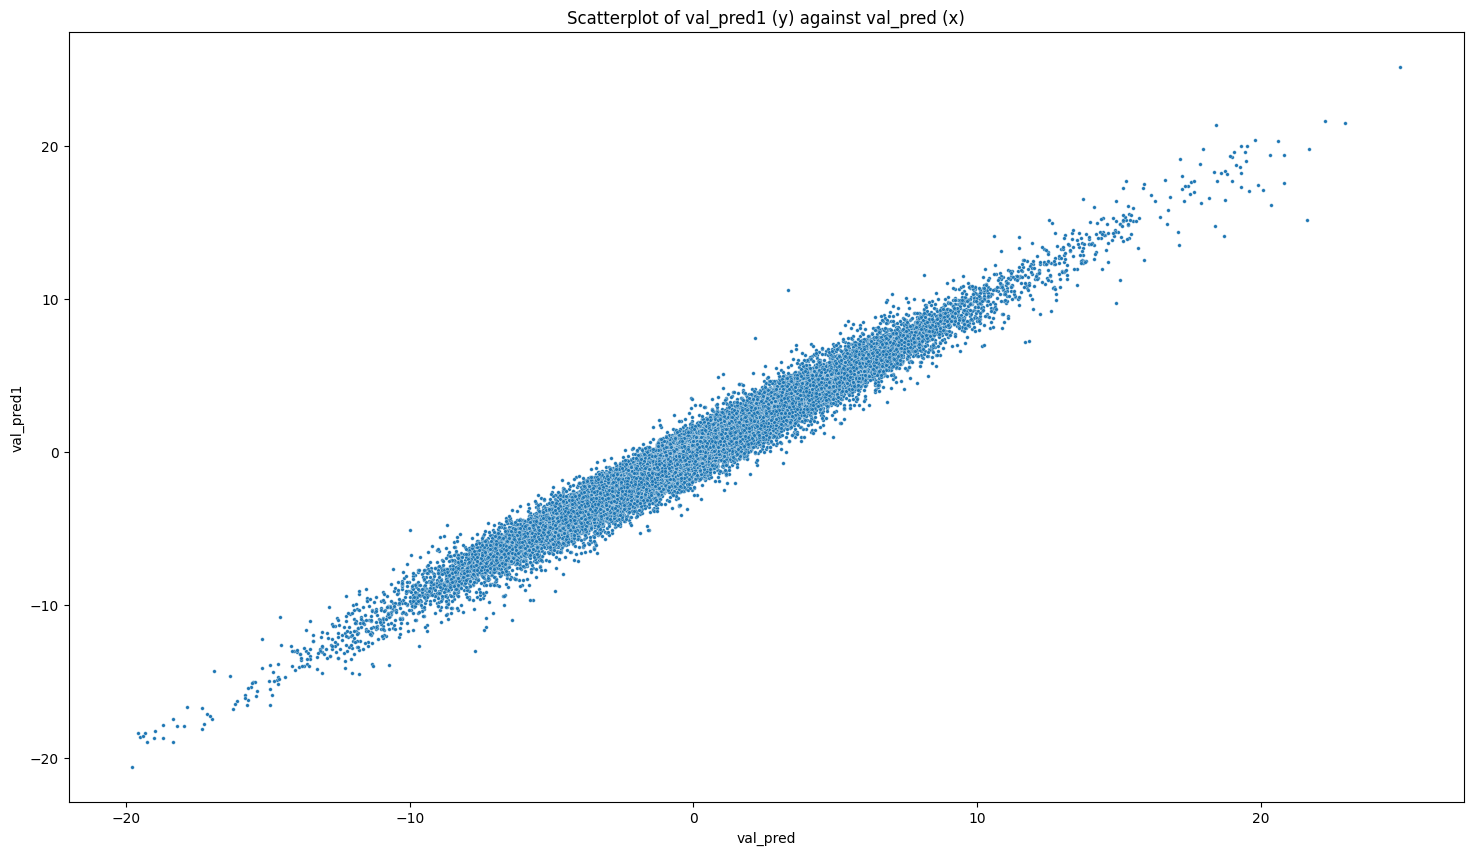

In [136]:
plot_scatterplot(lgbm, x_col="val_pred", y_col="val_pred1")

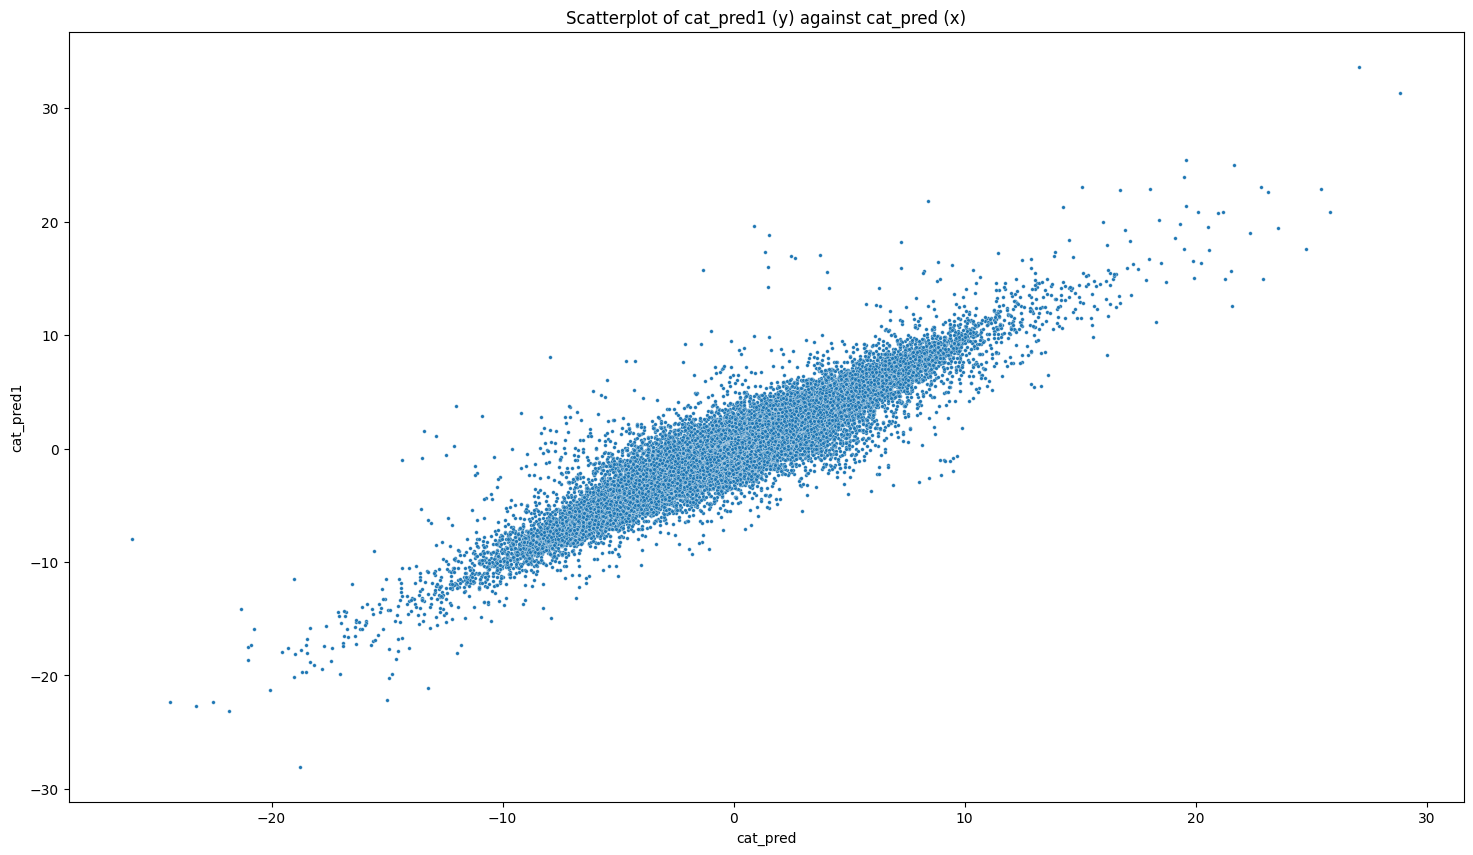

In [135]:
plot_scatterplot(lgbm, x_col="cat_pred", y_col="cat_pred1")

# Try Stack Logistic Regression

In [198]:
lgbm[["cat_pred", "cat_pred1", "val_pred1", "val_pred", "target"]]

,cat_pred,cat_pred1,val_pred1,val_pred,target
0,-0.830997,-0.929836,-1.309504,-1.578251,2.779961
1,-0.810464,-0.884285,-0.726944,-0.964731,4.869700
2,-0.455012,-0.822082,-0.414411,-0.425402,6.250143
3,-0.093208,-0.452160,-0.194242,-0.213853,7.139444
4,0.487792,0.267143,0.533044,0.673420,8.139610
...,...,...,...,...,...
659940,-2.392395,-2.044426,-1.982899,-1.841747,-7.209778
659941,-1.628953,-1.010354,-0.575198,-0.811155,-9.750128
659942,1.252752,0.996103,1.173841,0.984923,3.629923
659943,0.750795,0.261070,0.397068,0.681712,4.760027


In [233]:
final_df = lgbm.merge(train.loc[:, META_COLUMNS + get_cols(train, ["flag", "signal", "bollinger"]) + ["clipped_target"]], on=META_COLUMNS, how="left")

In [234]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GroupKFold

In [235]:
features = ["cat_pred", "cat_pred1", "val_pred1", "val_pred"] + get_cols(train, ["flag", "signal", "bollinger"])

In [236]:
for col in final_df.columns:
    final_df[col] = final_df[col].fillna(final_df[col].mean())

In [237]:
group_kfold = GroupKFold()

In [257]:
%%time
val_pred_list, val_gt_list = [], []
for tr_index, val_index in tqdm(group_kfold.split(final_df, final_df["target"], groups=final_df["stock_id"])):
    X_val = final_df.loc[val_index, features]
    X_train = final_df.loc[tr_index, features]
    y_val = final_df.loc[val_index, "target"]
    y_train = final_df.loc[tr_index, "clipped_target"]
    
    # r = Ridge()
    cb = CatBoostRegressor(verbose=0)
    cb.fit(X_train, y_train)
    val_pred_list.extend(list(cb.predict(X_val)))
    val_gt_list.extend(y_val.tolist())

5it [01:15, 15.11s/it]

CPU times: user 7min 25s, sys: 24.1 s, total: 7min 49s
Wall time: 1min 15s


In [258]:
pd.Series(np.array(val_pred_list) - np.array(val_gt_list)).abs().mean()

5.705074519898685

5.678458627763317